## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project **The goal** is to understand the results of an A/B test run by an e-commerce website, working through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to be 42
random.seed(42)

In [6]:
# Reading the dataframe and printing the first 5 rows 
df = pd.read_csv(r'\\ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [7]:
# The Number of rows in the DF
df.shape[0]

294478

c. The number of unique users in the dataset.

In [8]:
# The Number of unique users id in the DF
df.user_id.nunique()

290584

d. The proportion of users converted.

In [9]:
# proportion of users converted
df.query('converted == 1').shape[0]/df.shape[0]

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [10]:
# The number of times the new_page and treatment don't line up.
df.query("landing_page == 'new_page' and group == 'control'").shape[0] + df.query("landing_page == 'old_page' and group == 'treatment'").shape[0]

3893

f. Do any of the rows have missing values?

In [11]:
#checking if the df has any missing values
df.isnull().any()

user_id         False
timestamp       False
group           False
landing_page    False
converted       False
dtype: bool

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page. 

a.creating a new dataset that meets the specifications 
Store your new dataframe in **df2**.

In [12]:
# Removing the rows where treatment doesn't match with new_page or 
#control doesn't match with old_page then save clean DataFrame in to df2
df_treatment = df.query("landing_page == 'old_page' and group == 'treatment'").index
df_control   = df.query("landing_page == 'new_page' and group == 'control'").index
total_drop_index = df_treatment.append(df_control)
df2 = df.drop(total_drop_index)

In [13]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

a. How many unique **user_id**s are in **df2**?

In [14]:
# The Number of unique users id in the DF2
df2.user_id.nunique()

290584

In [15]:
# getting the duplicated user_id in DF2
df2[df2.user_id.duplicated()].user_id

2893    773192
Name: user_id, dtype: int64

In [16]:
# row information for the repeat user_id
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Removing **one** of the rows with a duplicate **user_id**, but keeping your dataframe as **df2**.

In [17]:
#dropping the duplicate record
df2.drop(df2[df2.user_id.duplicated()].index, inplace=True)

In [18]:
#Test
df2.user_id.duplicated().sum()

0

a. What is the probability of an individual converting regardless of the page they receive?

In [19]:
# the probability that an individual converted regardless of the page they receive
df2.query('converted == 1').shape[0]/df2.shape[0]

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [20]:
# the probability that an individual in the control group converted
control_p = df2.query('converted == 1 and group == "control"').shape[0]/df2.query('group == "control"').shape[0]
control_p

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [21]:
# the probability that an individual in the treatment group converted
treatment_p = df2.query('converted == 1 and group == "treatment"').shape[0]/df2.query('group == "treatment"').shape[0]
treatment_p

0.11880806551510564

d. What is the probability that an individual received the new page?

In [22]:
# the probability that an individual received the new page
df2.query('landing_page == "new_page"').shape[0]/df2.shape[0]

0.5000619442226688

e. Considering the results: **Explanation**

**From the results of the probability analysis, the New_page conversion rate (0.119) is lower than the Old_page conversion rate (0.12) with a very little difference, also there's an equal opportunity that an individual in each group can receive each page.
These results suggest staying with the Old_page, However there's not enough evidence to say that the new treatment page leads to less conversion**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, 
- **Hypothesis**

<div style="text-align: center"> 1. $H_{0}$ : ($P_{new}$ - $P_{old}$ <= 0) </div>
<div style="text-align: center"> 2. $H_{1}$ : ($P_{new}$ - $P_{old}$ > 0)  </div>

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Using a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem. 

a. What is the **convert rate** for $p_{new}$ under the null? 

In [23]:
# assumnig that the P_new and P_old have equal convertion rate
# conversion rate for new page
p_new = df2["converted"].mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [24]:
# conversion rate for old page same as the p_new under the null hypothesis
p_old = df2["converted"].mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [25]:
# the number of individuals in the treatment group
n_new = df2.query('group == "treatment"').shape[0]
n_new

145310

d. What is $n_{old}$?

In [26]:
# the number of individuals in the control group
n_old = df2.query('group == "control"').shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [27]:
# simulating n_new transactions with conversion probability of P_new
new_page_converted = np.random.choice([0,1], size = n_new, p=[(1-p_new), p_new])
new_page_converted

array([0, 0, 0, ..., 0, 0, 1])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
# simulating n_old transactions with conversion probability of P_old
old_page_converted = np.random.choice([0,1], size = n_old, p=[(1-p_old), p_old])
old_page_converted

array([0, 0, 0, ..., 1, 1, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
new_page_converted.mean() - old_page_converted.mean()

0.0009201652436779811

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [25]:
# Simulating 10,000  𝑝𝑛𝑒𝑤  -  𝑝𝑜𝑙𝑑  values using this same process as before and storing them in a P_diffs list 
p_diffs = []
for _ in range (10000):
    new_page_converted = np.random.choice([0,1], n_new, p=[(1-p_new),p_new])
    old_page_converted = np.random.choice([0,1], n_old, p=[(1-p_old),p_old])
    p_diff = (new_page_converted.mean() - old_page_converted.mean())
    p_diffs.append(p_diff)
# creating a numpy array for p_diffs
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  

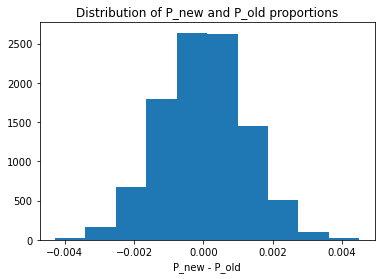

In [26]:
# Plotting a histogram of the P_diffs 
plt.hist(p_diffs)
plt.title('Distribution of P_new and P_old proportions')
plt.xlabel('P_new - P_old');

**The histogram seems to be normally distributed**

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [27]:
# compute observed difference in the actual means of the control and treatment 
obs_diff = treatment_p -control_p

In [28]:
#calculating the p-value
p =(p_diffs > obs_diff).mean()
p

0.904

k. **explanation:**

**In Part (j), I've calculated the P-value (0.9081) which is the probability of observing the statistic (or one more extreme in favor of the alternative) if the null hypothesis is true, the high value suggest the the null Hypothesis is true and our statistic came from the null hypothesis, so we fail to reject the null hypothesis**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [29]:
#importing statsmodels
import statsmodels.api as sm

#setting variables for the stats model
convert_old = df2.query('group == "control" and converted == 1').shape[0]
convert_new = df2.query('group == "treatment" and converted == 1').shape[0]
n_old = df2.query('group == "control"').shape[0]
n_new = df2.query('group == "treatment"').shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [30]:
# computing the z-score and p-value through python's library statsmodels
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative= 'smaller')
z_score, p_value

(1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

In [31]:
# Getting the critical value of Z-score to compare it to our results.
from scipy.stats import norm

# The percentage of the significance of z-score is
print(norm.cdf(z_score))

# What is the critical value at 95% confidence at type I error
print(norm.ppf(1-0.05))


0.9050583127590245
1.6448536269514722


**Z- Score :** is 1.31 standard deviations above the mean of the population and below the critical value of 1.64 which means that we fail to reject the Null hypothesis also **p_value** is 0.91 which is consistent with the results in parts j and k, the P-value is higher than type 1 error rate which means we fail to reject the Null hypoythesis again.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**We should be performing a logistic regression**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However,  first we need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [32]:
#adding an intercept column to df2 
df2['intercept'] = 1
# adding an ab_page column as a dummy variable for the categorical column (landing_page)
df2['ab_page']   = pd.get_dummies(df2['landing_page'])['new_page']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [33]:
# using statsmodels to import logistic regression model then fitting the model
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of the model below, and use it as necessary to answer the following questions.

In [34]:
#Print results of the logistic regression model
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 13 Jan 2021   Pseudo R-squ.:               8.077e-06
Time:                        22:51:21   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

In [35]:
# exponentiating the results summary to interpret the values
np.exp(results.params)

intercept    0.136863
ab_page      0.985123
dtype: float64

**Interpretation: if a user uses the new page he or she is 0.985 times likely to convert, which is still a very low value (less than 1)**

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  

P-value : 0.190
it differs from the previous value in part II because the hypothsis here is different
**Null and alternative hypotheses associated with the logistic regression model is :
$$ H_0: p_{new} = p_{old} $$$$ H_1: p_{new} \neq p_{old} $$**

**The Null and alternative hypothesis associated with th A/B testing in Part II was one sided 

**It's useful to discuss adding new variable (exploratory) to the regression model because we're interested in understanding the relevance/importance of each variable.
Adding a variable to a logistic regression model will cause a bias reduction in the coefficients estimates but an increase in their variances. Since you never know what are the real relevant variables, you need to balance this bias-variance trade-off.
[Resource link](https://stats.stackexchange.com/questions/304707/costs-and-benefits-of-adding-more-variables-to-multiple-regression)**

**Also we need to check if the variables that were fit in the model are independent of each other to avoid multicollinearity(so that the effect of each on the regression model becomes less precise.**

**While it is tempting to include as many input variables as possible, this can dilute true associations and lead to large standard errors with wide and imprecise confidence intervals, or, conversely, identify spurious associations. The conventional technique is to first run the univariate analyses (i.e., relation of the outcome with each predictor, one at a time) and then use only those variables which meet a preset cutoff for significance to run a multivariable model and to not overcomplicate the model.
[Resource link](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5543767/)**



In [36]:
# Reading countries df 
countries_df = pd.read_csv('./countries.csv')
# defining a new df with combing the countries df
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [37]:
#printing the 1st 5 rows of df_new
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [38]:
#checking the unique values in (country) column
df_new.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [39]:
### Creating the necessary dummy variables
df_new[['CA','UK', 'US']] = pd.get_dummies(df_new['country'])
# Printing 1st 5 rows in the new df 
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [40]:
# applying the logistic regression model on countries exploratory variables setting US as the baseline
logit_mod = sm.Logit(df_new['converted'],df_new[['intercept','UK','CA']])
results2 = logit_mod.fit()
results2.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Wed, 13 Jan 2021   Pseudo R-squ.:               1.521e-05
Time:                        22:53:05   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
CA            -0.0408      0.027     -1.518      0.129      -0.093       0.012
==============================================================================
"""

In [41]:
# exponentiating the results summary to interpret the values
np.exp(results2.params)

intercept    0.135779
UK           1.009966
CA           0.960018
dtype: float64

**Interpretation:**

1- If an individual was from UK , he/she is 1.0099 more likely to make a conversion than if he/she was from the US, holding all other variables constant.

2-If an individual was from CA , he/she is 0.96 more likely to make a conversion than if he/she was from the US, holding all other variables constant.


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and conclusions based on the results.

In [42]:
### Fit Your Linear Model And Obtain the Results
logit_mod = sm.Logit(df_new['converted'],df_new[['intercept','UK','CA','ab_page']])
results3 = logit_mod.fit()
results3.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Wed, 13 Jan 2021   Pseudo R-squ.:               2.323e-05
Time:                        22:53:37   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
==============================================================================
"""

In [43]:
# exponentiating the results summary to interpret the values
np.exp(results3.params)

intercept    0.136795
UK           1.009932
CA           0.960062
ab_page      0.985168
dtype: float64

**Interpretation:**

1-if an individual uses the new test page, he/she is 0.985 more likely to make a conversion than using the old page, holding all other variables constant.

2- If an individual is from UK , he/she is 1.0099 more likely to make a conversion than if he was from the US, holding all other variables constant.

3.If an individual is from CA , he/she is 0.96 more likely to make a conversion than if he was from the US, holding all other variables constant.

In [44]:
#Testing interaction between page and country to see if there significant effects on conversion
# Creating Higher order variables
df_new['US_ab_page'] = df_new['US'] * df_new['ab_page']
df_new['CA_ab_page'] = df_new['CA'] * df_new['ab_page']

In [50]:
### Fit logistic regression Model with the new columns of interactions
logit_mod = sm.Logit(df_new['converted'],df_new[['intercept', 'US_ab_page', 'CA_ab_page','US','CA','ab_page']])
results4 = logit_mod.fit()
results4.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Wed, 13 Jan 2021   Pseudo R-squ.:               3.482e-05
Time:                        23:05:26   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9922      0.016   -123.457      0.000      -2.024      -1.961
US_ab_page    -0.0314      0.027     -1.181      0.238      -0.084       0.021
CA_ab_page    -0.0783      0.057     -1.378      0.168      -0.190       0.033
US             0.0057      0.019      0.306      0.760      -0.031       0.043
CA            -0.0118      0.040     -0.296      0.767      -0.090       0.066
ab_page        0.0108      0.023      0.475      0.635      -0.034       0.056
==============================================================================
"""

In [51]:
# exponentiating the results summary to interpret the values
np.exp(results4.params)

intercept     0.136392
US_ab_page    0.969090
CA_ab_page    0.924703
US            1.005761
CA            0.988285
ab_page       1.010893
dtype: float64

**Interactions between page and countries  don't seem to make a significant impact on the results just as interpreted before, differences remain statistically insignificant, and we can't reject the Null hypothesis**

<a id='conclusions'></a>
## Conclusions

After analyzing the results of the 3 methods (probability, A/B testing and Logistic Regression model) to help the company understand the impact of deciding whether or not to proceed with the new page launching.
the three methods' results were consistent and suggested the the old page performance is better than the new page with no  statistical evidence to reject the null hypothesis.

However, in the real-world of online business, there are limitations we need to work with. In A/B testing we are limited by the time, resources and users we are happy to commit to any given test. There are some good practices that should be followed irrespective of what the sample sizes allow. For example, analyzing (sequential) tests on a weekly basis and not running tests for less than a week. For many businesses Tuesdays are not the same as Sundays, and even if you can run a satisfactory test in 3 days, you better plan it for a full seven days. Other best-practice advice can be found in white papers and books written by experts in the field.[Resource Link](http://blog.analytics-toolkit.com/2017/statistical-significance-ab-testing-complete-guide/)

An advice here for best A/B testing practice in this [link](http://blog.analytics-toolkit.com/2017/statistical-significance-ab-testing-complete-guide/):
"My advice is to weigh the costs for designing, preparing and running the A/B test against the potential benefits (with a reasonable future extrapolation, e.g. several years) and see the sample sizes (and thus time) required by several different combinations of values for the three main parameters (significance, power, minimum effect size). Then, chose a statistical design that hits closest to the perfect balance. Using a flexible sequential testing framework such as AGILE can make the decision on the minimum effect size much easier, since in case the true difference is much larger or much smaller, the test will simply stop early so the efficiency sacrificed will be minimal
While I don’t think there is a recipe for a perfect A/B test, I think the above advice for making a choice while facing several trade-offs is a helpful starting point for CRO and UX practitioners".


